In [17]:
#ignore if not windows
import winsound

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.semi_supervised import LabelPropagation
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import helper

In [19]:
nominal_sample = pd.read_csv('samples/2015_nominal_samples_n1.csv')
gray_sample = pd.read_csv('samples/2015_gray_samples_n1.csv')
failure_sample = pd.read_csv('samples/2015_failure_samples_n1.csv')

In [20]:
nominal_sample = nominal_sample.dropna(axis=0, thresh=20).dropna(axis=1)
failure_sample = failure_sample.dropna(axis=0, thresh=20).dropna(axis=1)
gray_sample    = gray_sample.dropna(axis=0, thresh=20).dropna(axis=1)
gray_sample.failure = 1
nominal_sample = nominal_sample.sample(frac=(failure_sample.shape[0]+gray_sample.shape[0])/nominal_sample.shape[0])
data_curr = pd.concat([nominal_sample, failure_sample, gray_sample])
data_curr = data_curr.sample(frac=1)

In [21]:
#normalized
feature_columns = [ 'smart_1_normalized', 'smart_3_normalized', 'smart_4_normalized', 'smart_5_normalized',
           'smart_7_normalized','smart_12_normalized', 'smart_194_normalized', 
           'smart_197_normalized', 'smart_198_normalized', 'smart_199_normalized']

In [50]:
#raw
feature_columns = [ 'smart_1_raw', 'smart_3_raw', 'smart_4_raw', 'smart_5_raw',
           'smart_7_raw','smart_12_raw', 'smart_194_raw', 
           'smart_197_raw', 'smart_198_raw', 'smart_199_raw']

In [51]:
scale = 'sk'
train_size = .66

if scale=='sk':
    y_curr = data_curr['failure']
    x_curr = data_curr[feature_columns]
    x_train, x_val, y_train, y_val = train_test_split(x_curr, y_curr, train_size=train_size)

    x_train = x_train.values
    x_val = x_val.values
    y_train = y_train.values
    y_val = y_val.values

    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_val = scaler.transform(x_val)
elif scale=='sk_manu':
    y_curr = data_curr['failure']
    x_train, x_val, y_train, y_val = train_test_split(data_curr, y_curr, train_size=train_size)

    train_norm = pd.DataFrame()
    test_norm = pd.DataFrame()
    manufacturers = ['ST','Hi','WD','To','HG']
    for man in manufacturers:
        data_sub = x_train[[i[:2].lower()==man.lower() for i in x_train.model]]
        test_sub = x_val[[i[:2].lower()==man.lower() for i in x_val.model]]
        
        scaler = StandardScaler()
        data_sub = scaler.fit_transform(data_sub[feature_columns])
        test_sub = scaler.transform(test_sub[feature_columns])
        
        train_norm = pd.concat([train_norm,pd.DataFrame(data_sub)])
        test_norm = pd.concat([test_norm,pd.DataFrame(test_sub)])
        
        
    x_train = train_norm.sample(frac=1)#[feature_columns]
    x_val = test_norm.sample(frac=1)#[feature_columns]

    x_train = x_train.values
    x_val = x_val.values
    y_train = y_train.values
    y_val = y_val.values
elif scale=='manu':
    y_curr = data_curr['failure']
    x_train, x_val, y_train, y_val = train_test_split(data_curr, y_curr, train_size=train_size)
    
    train_norm = pd.DataFrame()
    test_norm = pd.DataFrame()
    manufacturers = ['ST','Hi','WD','To','HG']
    for man in manufacturers:    
        data_sub = x_train[[i[:2].lower()==man.lower() for i in x_train.model]]
        test_sub = x_val[[i[:2].lower()==man.lower() for i in x_val.model]]
        max_ = data_sub.max()
        del max_['date']
        min_ = data_sub.min()
        del min_['date']
        for col in feature_columns:
            range_ = max_[col] - min_[col]
            if range_==0:
                range_ = 1
            data_sub[col] = (data_sub[col] - min_[col])/range_
            test_sub[col] = (test_sub[col] - min_[col])/range_
        train_norm = pd.concat([train_norm,data_sub])
        test_norm = pd.concat([test_norm,test_sub])
        
    x_train = train_norm.sample(frac=1)[feature_columns]
    x_val = test_norm.sample(frac=1)[feature_columns]

    x_train = x_train.values
    x_val = x_val.values
    y_train = y_train.values
    y_val = y_val.values
    
else:
    y_curr = data_curr['failure']
    x_curr = data_curr[feature_columns]
    x_train, x_val, y_train, y_val = train_test_split(x_curr, y_curr, train_size=train_size)

    x_train = x_train.values
    x_val = x_val.values
    y_train = y_train.values
    y_val = y_val.values

C:\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2069: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [52]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x_train)

In [53]:
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [54]:
finalDf = pd.concat([principalDf, pd.DataFrame(y_train)], axis = 1)

In [55]:
finalDf.columns

Index(['principal component 1', 'principal component 2', 0], dtype='object')

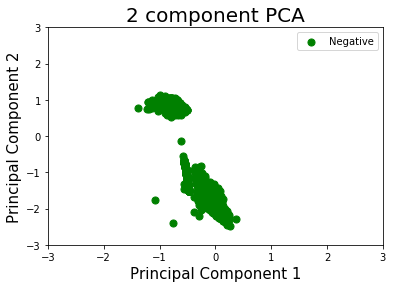

In [28]:
plt.xlabel('Principal Component 1', fontsize = 15)
plt.ylabel('Principal Component 2', fontsize = 15)
plt.title('2 component PCA', fontsize = 20)
targets = [0]#,1]
colors = ['g']#, 'r']
for target, color in zip(targets,colors):
    indicesToKeep = y_train == target
    plt.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
plt.legend(["Negative"])
plt.ylim([-3,3])
plt.xlim([-3,3])
plt.show()

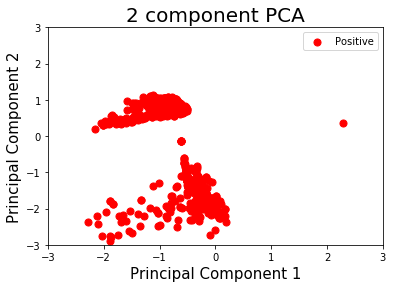

In [29]:
plt.xlabel('Principal Component 1', fontsize = 15)
plt.ylabel('Principal Component 2', fontsize = 15)
plt.title('2 component PCA', fontsize = 20)
targets = [1]
colors = [ 'r']
for target, color in zip(targets,colors):
    indicesToKeep = y_train == target
    plt.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
plt.legend(["Positive"])
plt.ylim([-3,3])
plt.xlim([-3,3])
plt.show()

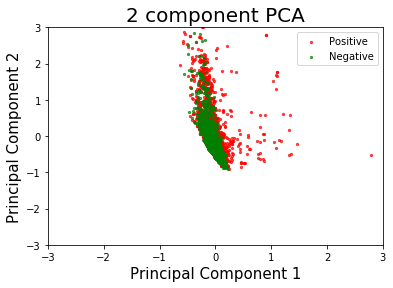

In [66]:
plt.xlabel('Principal Component 1', fontsize = 15)
plt.ylabel('Principal Component 2', fontsize = 15)
plt.title('2 component PCA', fontsize = 20)
targets = [1,0]
colors = ['r','g']
alphas = [.1,.1]
for target, color, alpha in zip(targets,colors,alphas):
    indicesToKeep = y_train == target
    plt.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 5, alpha = .7)
plt.legend(["Positive","Negative"])
plt.ylim([-3,3])
plt.xlim([-3,3])
plt.show()

In [31]:
# *** MODELS ***
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters, n_init=10)

In [33]:
model_results = {}

In [34]:
kmeans.fit(x_train)

labels = [i for i in range(n_clusters)]

y_pred = kmeans.labels_
for i in range(n_clusters):
    labels[i] = y_pred[y_pred==i].mean()

    
model = kmeans
pred_train = model.predict(x_train)
pred_val = model.predict(x_val)

pred_train = np.array([labels[i] for i in pred_train])
pred_val = np.array([labels[i] for i in pred_val])
    
eval_v = helper.evaluation_metrics(pred_val, y_val)
eval_t = helper.evaluation_metrics(pred_train, y_train)
model_results[model] = {}
model_results[model]['train'] = eval_t
model_results[model]['val'] = eval_v

In [35]:
label_prop = LabelPropagation(gamma=100)

label_prop.fit(x_train, y_train)
model = label_prop
pred_train = model.predict(x_train)
pred_val = model.predict(x_val)

eval_v = helper.evaluation_metrics(pred_val, y_val)
eval_t = helper.evaluation_metrics(pred_train, y_train)
model_results[model] = {}
model_results[model]['train'] = eval_t
model_results[model]['val'] = eval_v

In [ ]:
winsound.MessageBeep()

In [36]:
models = [kmeans,label_prop]

In [37]:
models_plot = [kmeans,label_prop]

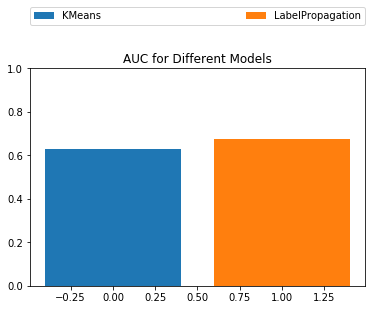

In [38]:
leg = []
data = []
for (i,model) in enumerate(models_plot):
    leg.append(str(model).split('(')[0])
    data.append(model_results[model]['val']['roc_auc'])
    plt.bar(i, model_results[model]['val']['roc_auc'])
plt.legend(leg,bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.ylim([0,1])
plt.title("AUC for Different Models")
plt.show()

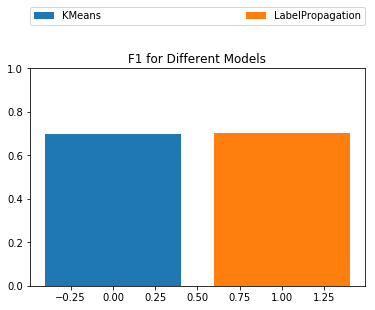

In [39]:
leg = []
data = []
for (i,model) in enumerate(models_plot):
    leg.append(str(model).split('(')[0])
    data.append(model_results[model]['val']['f1'])
    plt.bar(i, model_results[model]['val']['f1'])
plt.legend(leg,bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.ylim([0,1])
plt.title("F1 for Different Models")
plt.show()

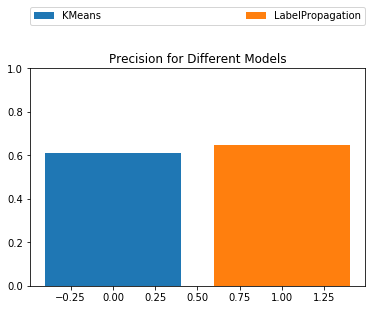

In [40]:
leg = []
data = []
for (i,model) in enumerate(models_plot):
    leg.append(str(model).split('(')[0])
    data.append(model_results[model]['val']['precision'])
    plt.bar(i, model_results[model]['val']['precision'])
plt.legend(leg,bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.ylim([0,1])
plt.title("Precision for Different Models")
plt.show()

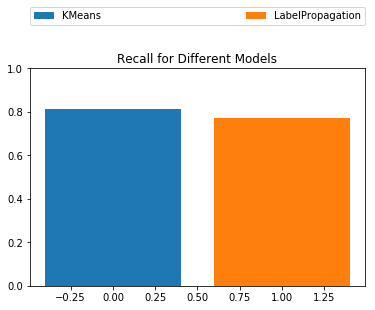

In [41]:
leg = []
data = []
for (i,model) in enumerate(models_plot):
    leg.append(str(model).split('(')[0])
    data.append(model_results[model]['val']['recall'])
    plt.bar(i, model_results[model]['val']['recall'])
plt.legend(leg,bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.ylim([0,1])
plt.title("Recall for Different Models")
plt.show()

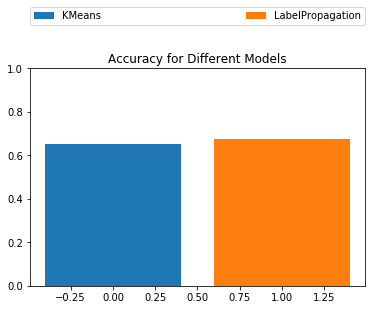

In [42]:
leg = []
data = []
for (i,model) in enumerate(models_plot):
    leg.append(str(model).split('(')[0])
    data.append(model_results[model]['val']['accuracy'])
    plt.bar(i, model_results[model]['val']['accuracy'])
plt.legend(leg,bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("Accuracy for Different Models")
plt.ylim([0,1])
plt.show()

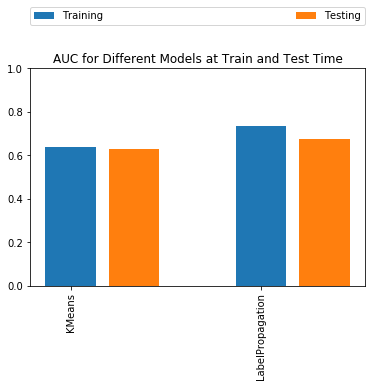

In [43]:
data_t = []
data_v = []
for (i,model) in enumerate(models_plot):
    data_t.append(model_results[model]['train']['roc_auc'])
    data_v.append(model_results[model]['val']['roc_auc'])
plt.bar([3*i for i in range(len(models_plot))], data_t)
plt.bar([3*i+1 for i in range(len(models_plot))], data_v)
plt.xticks(np.arange(0,3*len(models_plot),3), [str(m).split('(')[0] for m in models_plot],
          rotation='vertical')
plt.legend(["Training","Testing"],bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("AUC for Different Models at Train and Test Time")
plt.ylim([0,1])
plt.show()

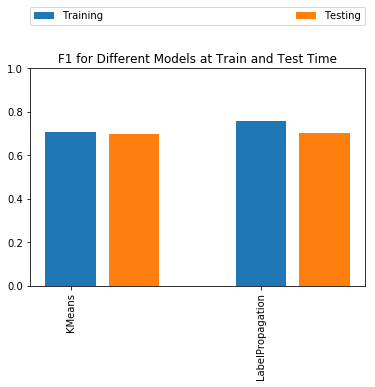

In [44]:
data_t = []
data_v = []
for (i,model) in enumerate(models_plot):
    data_t.append(model_results[model]['train']['f1'])
    data_v.append(model_results[model]['val']['f1'])
plt.bar([3*i for i in range(len(models_plot))], data_t)
plt.bar([3*i+1 for i in range(len(models_plot))], data_v)
plt.xticks(np.arange(0,3*len(models_plot),3), [str(m).split('(')[0] for m in models_plot],
          rotation='vertical')
plt.legend(["Training","Testing"],bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("F1 for Different Models at Train and Test Time")
plt.ylim([0,1])
plt.show()

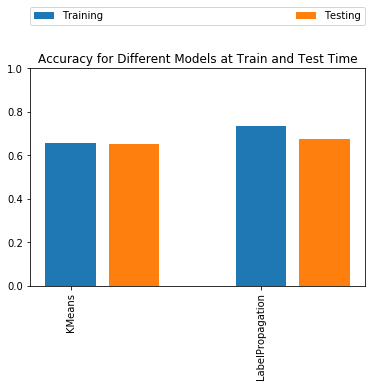

In [45]:
data_t = []
data_v = []
for (i,model) in enumerate(models_plot):
    data_t.append(model_results[model]['train']['accuracy'])
    data_v.append(model_results[model]['val']['accuracy'])
plt.bar([3*i for i in range(len(models_plot))], data_t)
plt.bar([3*i+1 for i in range(len(models_plot))], data_v)
plt.xticks(np.arange(0,3*len(models_plot),3), [str(m).split('(')[0] for m in models_plot],
          rotation='vertical')
plt.legend(["Training","Testing"],bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("Accuracy for Different Models at Train and Test Time")
plt.ylim([0,1])
plt.show()

In [48]:
metrics_ = pd.DataFrame()
table_models = [('KMeans',kmeans),('LabelProp',label_prop)]
for (i,model) in enumerate(table_models):
    name = str(model[0])
    model = model[1]
    current = (model_results[model]['train']['accuracy'], model_results[model]['val']['accuracy'],
               model_results[model]['train']['roc_auc'], model_results[model]['val']['roc_auc'],
              model_results[model]['train']['f1'], model_results[model]['val']['f1'])
    metrics_ = pd.concat([metrics_,
                          pd.DataFrame([current],index=[name])])
metrics_.columns=['Training Accuracy','Test Accuracy','Training Auc','Test Auc','Training F1','Test F1']

In [49]:
metrics_


,Training Accuracy,Test Accuracy,Training Auc,Test Auc,Training F1,Test F1
KMeans,0.658622,0.650182,0.638600,0.628699,0.705801,0.698655
LabelProp,0.734781,0.676731,0.734618,0.677070,0.756344,0.703580


In [ ]:
# load future
f_nominal_sample = pd.read_csv('samples/2018_nominal_samples_n1.csv')
f_gray_sample = pd.read_csv('samples/2018_gray_samples_n1.csv')
f_failure_sample = pd.read_csv('samples/2018_failure_samples_n1.csv')

#clean future
f_nominal_sample = f_nominal_sample.dropna(axis=0, thresh=20).dropna(axis=1)
f_failure_sample = f_failure_sample.dropna(axis=0, thresh=20).dropna(axis=1)
f_gray_sample    = f_gray_sample.dropna(axis=0, thresh=20).dropna(axis=1)
f_gray_sample.failure = 1
#f_nominal_sample = f_nominal_sample.sample(frac=(f_failure_sample.shape[0]+f_gray_sample.shape[0])/f_nominal_sample.shape[0])

#create test set
data_curr = pd.concat([f_nominal_sample, f_failure_sample])
data_curr = data_curr.sample(frac=1)
f_y_test = data_curr['failure']
f_x_test = data_curr[feature_columns]
f_x_test = scaler.transform(f_x_test)

In [ ]:
for model in models:
    pred_test = model.predict_proba(f_x_test)[:,1]
    eval_f = helper.evaluation_metrics(pred_test, f_y_test)
    model_results[model]['future'] = eval_f

In [ ]:
winsound.MessageBeep()

In [ ]:
data_t = []
data_v = []
data_f = []
for (i,model) in enumerate(models_plot):
    data_t.append(model_results[model]['train']['accuracy'])
    data_v.append(model_results[model]['val']['accuracy'])
    data_f.append(model_results[model]['future']['accuracy'])
plt.bar([4*i for i in range(len(models_plot))], data_t)
plt.bar([4*i+1 for i in range(len(models_plot))], data_v)
plt.bar([4*i+2 for i in range(len(models_plot))], data_f)
plt.xticks(np.arange(1,4*len(models_plot),4), [str(m).split('(')[0] for m in models_plot],
          rotation='vertical')
plt.legend(["Training","Testing","Future"],bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("Accuracy for Different Models at Train and Test and Future")
plt.ylim([0,1])
plt.show()

In [ ]:
data_t = []
data_v = []
data_f = []
for (i,model) in enumerate(models_plot):
    data_t.append(model_results[model]['train']['recall'])
    data_v.append(model_results[model]['val']['recall'])
    data_f.append(model_results[model]['future']['recall'])
plt.bar([4*i for i in range(len(models_plot))], data_t)
plt.bar([4*i+1 for i in range(len(models_plot))], data_v)
plt.bar([4*i+2 for i in range(len(models_plot))], data_f)
plt.xticks(np.arange(1,4*len(models_plot),4), [str(m).split('(')[0] for m in models_plot],
          rotation='vertical')
plt.legend(["Training","Testing","Future"],bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("Recall for Different Models at Train and Test and Future")
plt.ylim([0,1])
plt.show()

In [ ]:
model_results[models[0]]['val']['confusion'],model_results[models[0]]['future']['confusion']

In [ ]:
model_results[models[1]]['val']['confusion'],model_results[models[1]]['future']['confusion']

In [ ]:
model_results[models[2]]['val']['confusion'],model_results[models[2]]['future']['confusion']

In [ ]:
data_t = []
data_v = []
data_f = []
for (i,model) in enumerate(models_plot):
    data_t.append(model_results[model]['train']['roc_auc'])
    data_v.append(model_results[model]['val']['roc_auc'])
    data_f.append(model_results[model]['future']['roc_auc'])
plt.bar([4*i for i in range(len(models_plot))], data_t)
plt.bar([4*i+1 for i in range(len(models_plot))], data_v)
plt.bar([4*i+2 for i in range(len(models_plot))], data_f)
plt.xticks(np.arange(1,4*len(models_plot),4), [str(m).split('(')[0] for m in models_plot],
          rotation='vertical')
plt.legend(["Training","Testing","Future"],bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("AUC for Different Models at Train and Test and Future")
plt.ylim([0,1])
plt.show()

In [ ]:
data_t = []
data_v = []
data_f = []
for (i,model) in enumerate(models_plot):
    data_t.append(model_results[model]['train']['f1'])
    data_v.append(model_results[model]['val']['f1'])
    data_f.append(model_results[model]['future']['f1'])
plt.bar([4*i for i in range(len(models_plot))], data_t)
plt.bar([4*i+1 for i in range(len(models_plot))], data_v)
plt.bar([4*i+2 for i in range(len(models_plot))], data_f)
plt.xticks(np.arange(1,4*len(models_plot),4), [str(m).split('(')[0] for m in models_plot],
          rotation='vertical')
plt.legend(["Training","Testing","Future"],bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.title("F1 Score for Different Models at Train and Test and Future")
plt.ylim([0,1])
plt.show()

In [ ]:
tpr = model_results[models[1]]['future']['tpr']
fpr = model_results[models[1]]['future']['fpr']
auc = model_results[models[1]]['future']['roc_auc']

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (%s: area = %0.2f)' % (str(models[1]).split('(')[0],auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
tpr = model_results[models[2]]['future']['tpr']
fpr = model_results[models[2]]['future']['fpr']
auc = model_results[models[2]]['future']['roc_auc']

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
plt.figure()
lw = 2
for mod in models:
    tpr = model_results[mod]['val']['tpr']
    fpr = model_results[mod]['val']['fpr']
    auc = model_results[mod]['val']['roc_auc']
    plt.plot(fpr, tpr, 
             lw=lw, label='ROC curve (%s: area = %0.2f)' % (str(mod).split('(')[0],auc))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(bbox_to_anchor=(0., 1.2, 1., .102), loc=3,
           ncol=1, mode="expand", borderaxespad=0.)
plt.show()

In [ ]:
model_results[rfc100]